# Assignment 2

## Part 1: CNN Transfer Learning 

In [2]:
# Imports used for this notebook
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import time
import os

# Pre-trained models from Pytorch backend
from torchvision.models import vgg11, vgg11_bn
from torchvision.models import resnet18, resnet34
from torchvision.models import densenet121
from torchvision.models import mobilenet_v3_small

In [3]:
# Device business
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f'Device running this notebook: {device}')

DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/part1"

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Setting the Pytorch environment for saving the models
os.environ['TORCH_HOME'] = CHECKPOINT_PATH

# Method for setting the seed
def set_seed(seed):
    """
    Function for setting the seed for reproducibility & benchmarking.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(42)

Device running this notebook: cuda:0


In [4]:
# Initializing models
models = {
    'vgg11': vgg11,
    'vgg11_bn': vgg11_bn,
    'resnet18': resnet18,
    'resnet34': resnet34,
    'densenet121': densenet121,
    'mobilenet_v3_small': mobilenet_v3_small
}

# The top-1 accuracies retrieved from the pytorch website
model_top1_accs = [69.02, 70.37, 69.758, 73.314, 74.434, 67.668]

# Initializes the models if not downloaded already. Performs (optionally) GPU warmup.
def init_models(model_weights, gpu_warmup=False):
    for model_name, model in models.items():
        models[model_name] = model(weights=model_weights)
        models[model_name].to(device)
        # Run a couple of fake forward passes
        if gpu_warmup:
            num_runs = np.random.randint(3, 10)
            for run in range(num_runs):
                models[model_name](torch.rand((3, 224, 224)).unsqueeze(0).to(device))

# Using the IMAGENET1K_V1 weights for each model
init_models(model_weights='IMAGENET1K_V1', gpu_warmup=True)

In [5]:
# Helper functions for performing the inference times for the models
def time_inferences(num_passes, no_grad=True, batch_size=1, return_memory_usage=False):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    inference_times = {}
    if return_memory_usage:
        memory_buffer = []
    for model_name, model in models.items():
        models[model_name].eval()
        times = []
        outs = []
        with torch.no_grad() if no_grad else torch.enable_grad():
            for run in range(num_passes):
                start.record()
                outs.append(models[model_name](torch.rand((batch_size, 3, 224, 224)).to(device)))
                end.record()
                torch.cuda.synchronize()
                times.append(start.elapsed_time(end))
        inference_times[model_name] = np.mean(times)
        if return_memory_usage:
            memory_buffer.append(torch.cuda.memory_allocated()*1e-6) # Converting to MB
    if return_memory_usage:
        return inference_times, memory_buffer
    return inference_times

In [6]:
# Helper function for plotting the required graphs
def plot_inferences(inference_times, top1_accs):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(18, 5))
    model_names, times = zip(*inference_times.items())
    # Inference speed per model
    ax1.xaxis.set_tick_params(rotation=10)
    ax1.set_xlabel('Pre-Trained Models')
    ax1.set_ylabel('Average Inference Speed (ms)')
    ax1.plot(model_names, times, 'o')

    # Inference speed vs top1 acc
    ax2.set_xlabel('Average Inference Speed (ms)')
    ax2.set_ylabel('Model Top-1 accuracy')
    for i, model_name in enumerate(model_names):
        ax2.plot(times[i], top1_accs[i], "s", label=model_name)

    # Inference speed vs #parameters
    ax3.set_xlabel('Average Inference Speed (ms)')
    ax3.set_ylabel('Model Number of Parameters')
    for i, model_name in enumerate(model_names):
        num_params = sum(p.numel() for p in models[model_name].parameters())
        ax3.plot(times[i], num_params, "D", label=model_name)

    # Legend business
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                      box.width, box.height * 0.9])
    # Put a legend below current axis
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
               fancybox=True, shadow=True, ncol=3, prop={'size': 13})
    plt.show()

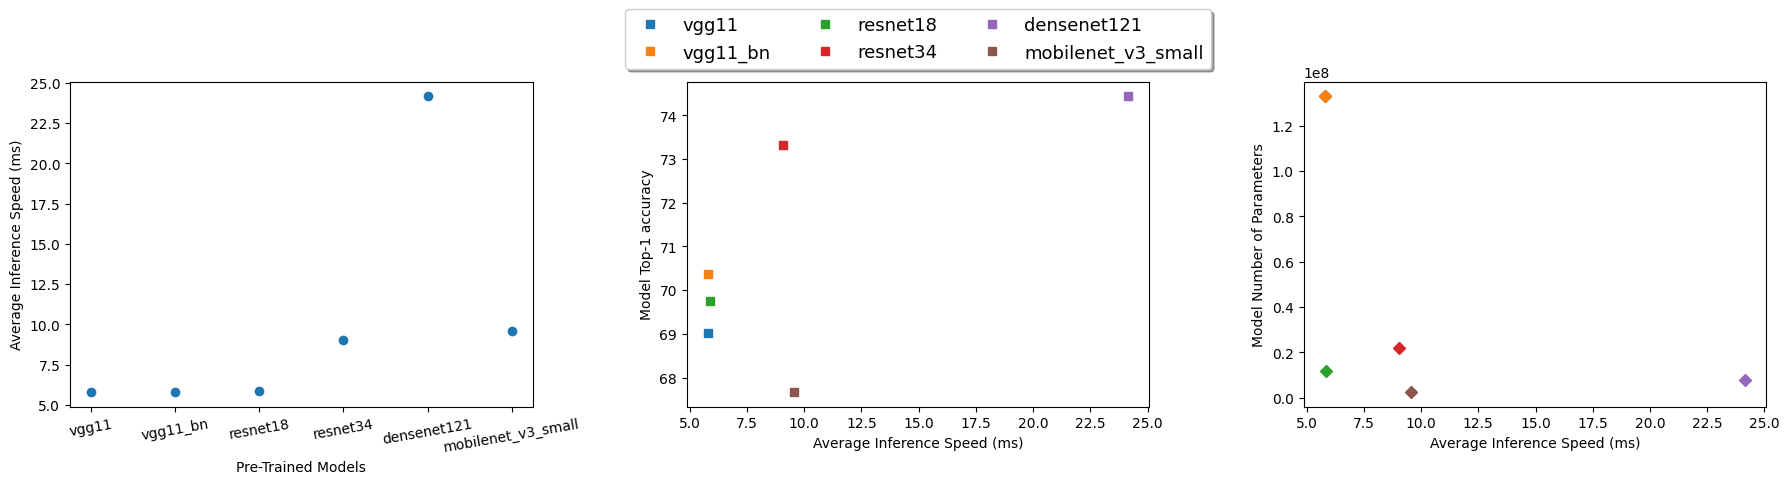

In [7]:
# Question 1.1 a)
avg_inference_times = time_inferences(num_passes=10, no_grad=True, batch_size=1)
plot_inferences(avg_inference_times, model_top1_accs)

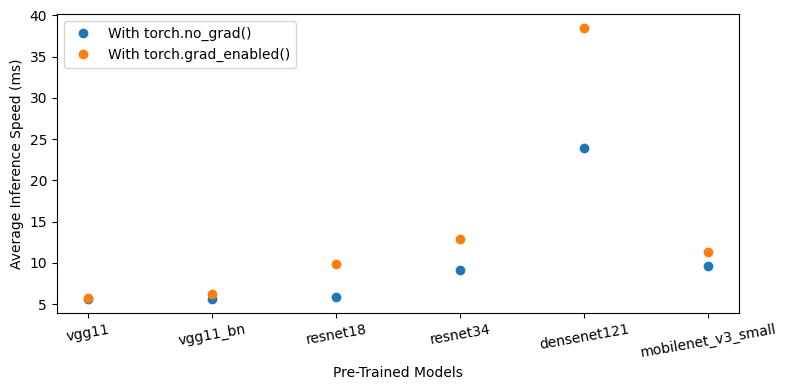

In [8]:
# Question 1.1 b)
avg_inference_times_no_grad = time_inferences(num_passes=10, no_grad=True)
avg_inference_times_grad_enabled = time_inferences(num_passes=10, no_grad=False)
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8, 4))
model_names, times_no_grad = zip(*avg_inference_times_no_grad.items())
times_grad_enabled = list(avg_inference_times_grad_enabled.values())
# Inference speed per model
ax.xaxis.set_tick_params(rotation=10)
ax.set_xlabel('Pre-Trained Models')
ax.set_ylabel('Average Inference Speed (ms)')
ax.plot(model_names, times_no_grad, 'o', label="With torch.no_grad()")
ax.plot(model_names, times_grad_enabled, 'o', label="With torch.grad_enabled()")
plt.legend()
plt.show()

In [11]:
# Question 1.1 c)
batch_size = 64 # todo change to 64
avg_inference_times_no_grad, no_grad_memory_usage = time_inferences(num_passes=1, no_grad=True, batch_size=batch_size, return_memory_usage=True)
avg_inference_times_grad_enabled, grad_enabled_memory_usage = time_inferences(num_passes=1, no_grad=False, batch_size=batch_size, return_memory_usage=True)
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8, 4))
model_names, times_no_grad = zip(*avg_inference_times_no_grad.items())
# Inference speed per model
ax.xaxis.set_tick_params(rotation=10)
ax.set_xlabel('Pre-Trained Models')
ax.set_ylabel('GPU vRAM usage (MB)')
ax.plot(model_names, no_grad_memory_usage, 'o', label="With torch.no_grad()")
ax.plot(model_names, grad_enabled_memory_usage, 'o', label="With torch.grad_enabled()")
plt.legend()
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 10.92 GiB total capacity; 5.55 GiB already allocated; 78.56 MiB free; 5.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 